Name: Hanh Tran

Class: DSC 550

Assignment: Analysis Case Study - German Credit Risk

## Problem Statement: 

Data science is often applied in the world of finance for pattern recognition and decision making. In particular, Banks usually have to make a decision on approving a loan based on a applicant's provided information. It is also oftern the case where there is asymmetrical information which can occur "in any situation involving a borrower and a lender when the borrower fails to disclose negative information about his or her real financial state. Or the borrower may simply fail to anticipate a worst-case scenario such as a job loss or an unanticipated expense." In a bank loan situation, the bank will come across two types of risks where if the applicant is a good credit risk, and the bank doesn't approve their loan, then the bank can risk loss of business. The other risk is if the applicant is actually a bad credit risk and the bank approves the loan, then that will result in a financial loss to the bank. 

We can use the analytical approach of logistical regression to minimize the risk and maximize profit on behalf of the bank by predicting who the bank should approve a loan to based on the dataset.    

## Proposal:

By using the german credit dataset and applying logistical analysis, I can analyze which applicant should be approved and which the bank can pass on. Since we have a credibility variable (1: credit-worthy and 0: not credit-worthy), this would be a supervised model. Since this is a binary classifier, Credit-worthy/Not credit-worthy, I will evaluate the performance of the classifier through the ROC curve which "compares the presence of true positives and false positives at every probability threshold."  

## Findings: 

The model is better at predicting a true negative or not beng credit-worthy than it is at identifying a true positive. This strategy aligns with a tight credit market where there is a lesser degree of a financial loss to the bank.  

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, average_precision_score, make_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
sns.set()
%matplotlib inline


In [2]:
df = pd.read_csv('datasets_german_credit_data.csv')
df.head()


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## Variables in Dataset
Age - Numeric

Sex - Categorical: Male, Female

Job - Numeric/Categorical: 0 — unskilled and non-resident, 1 — unskilled and resident, 2 — skilled, 3 — highly skilled)

Housing - Categorical: own, rent, free

Saving accounts - Categorical: little, moderate, quite rich, rich

Checking account - Numeric, amount in Deutsch Mark

Credit amount - Numeric, amount in Deutsch Mark

Duration - Numeric in month

Purpose - Categorical: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others

In [3]:
len(df)

1000

In [4]:
#get a quick look at the info of the data, we are missing a lot of values in the checking account variable and savings account
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


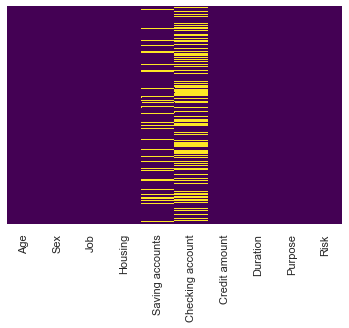

In [5]:
#get a visulization of missing data
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [6]:
#fill in other for missing values in Saving and Checking, keep those rows as other columns may be useful
df['Saving accounts'] = df['Saving accounts'].fillna('other')
df['Checking account'] = df['Checking account'].fillna('other')

In [7]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,other,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,other,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [8]:
#target variable is the risk, map to binary classifier - label encoding
df['Risk'] = df['Risk'].map({'good':1, 'bad':0})

In [9]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,other,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,49,male,1,own,little,other,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,0


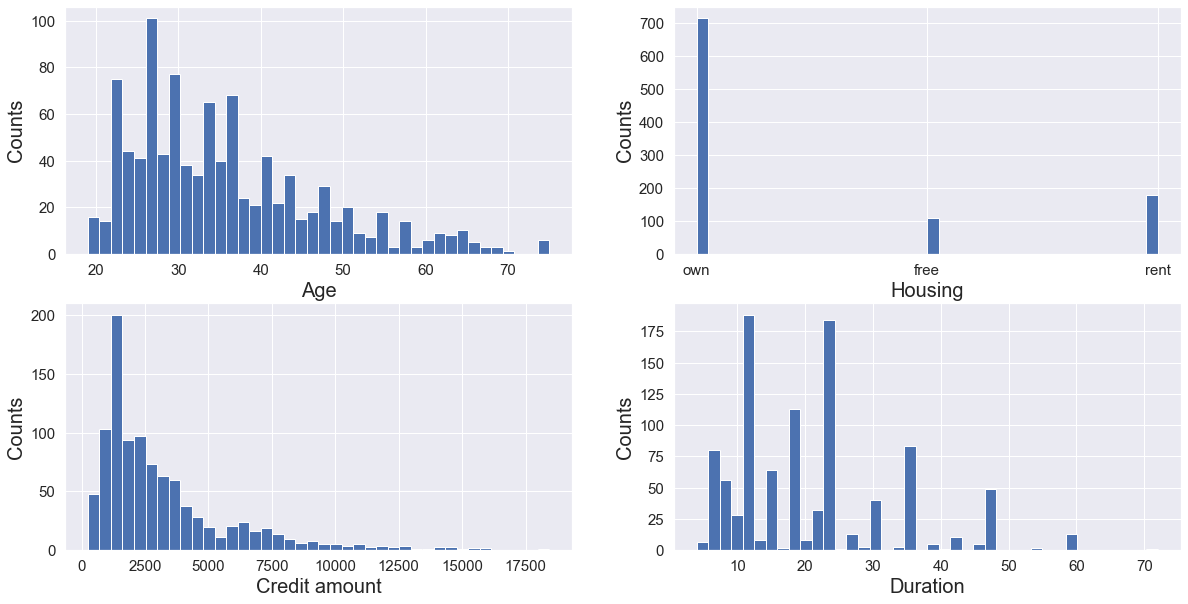

In [10]:
#get distribution of column variables, age, credit amount, Duration, Housing
# set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)
# make subplots 2x2
fig, axes = plt.subplots(nrows = 2, ncols = 2)
# Specify the features of interest
num_features = ['Age', 'Housing', 'Credit amount', 'Duration']
xaxes = num_features
yaxes = ['Counts', 'Counts', 'Counts', 'Counts']
# draw histograms
axes = axes.ravel()
for idx, ax in enumerate(axes):
    ax.hist(df[num_features[idx]].dropna(), bins=40)
    ax.set_xlabel(xaxes[idx], fontsize=20)
    ax.set_ylabel(yaxes[idx], fontsize=20)
    ax.tick_params(axis='both', labelsize=15)

In [11]:
#use One-hot encoding to convert categorical variables into indicator variables for model
cat_feats = ['Sex','Housing', 'Saving accounts', 'Checking account','Purpose']
#avoid multicollinearity with drop first
final_data = pd.get_dummies(df, columns=cat_feats, drop_first=True)

In [12]:
final_data.head()

,Age,Job,Credit amount,Duration,Risk,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_other,...,Checking account_moderate,Checking account_other,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,2,1169,6,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,22,2,5951,48,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,49,1,2096,12,1,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,45,2,7882,42,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,53,2,4870,24,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [13]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Age                          1000 non-null   int64
 1   Job                          1000 non-null   int64
 2   Credit amount                1000 non-null   int64
 3   Duration                     1000 non-null   int64
 4   Risk                         1000 non-null   int64
 5   Sex_male                     1000 non-null   uint8
 6   Housing_own                  1000 non-null   uint8
 7   Housing_rent                 1000 non-null   uint8
 8   Saving accounts_moderate     1000 non-null   uint8
 9   Saving accounts_other        1000 non-null   uint8
 10  Saving accounts_quite rich   1000 non-null   uint8
 11  Saving accounts_rich         1000 non-null   uint8
 12  Checking account_moderate    1000 non-null   uint8
 13  Checking account_other       1000 non-null   uint

In [19]:
#create a whole features dataset that can be used for train and validation data splitting
X = final_data.drop('Risk', axis=1) 

#create a whole target dataset that can be used for train and validation data splitting
y = final_data['Risk'] 

In [49]:
# split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size =0.3, stratify=y)
# number of samples in each set
print("No. of samples in training set: ", X_train.shape[0])
print("No. of samples in validation set:", X_val.shape[0])

# Good Risk and Bad risk
print('\n')
print('No. of Good risk and bad risk in the training set:')
print(y_train.value_counts())

print('\n')
print('No. of good risk and bad risk in the validation set:')
print(y_val.value_counts())


No. of samples in training set:  700
No. of samples in validation set: 300


No. of Good risk and bad risk in the training set:
1    490
0    210
Name: Risk, dtype: int64


No. of good risk and bad risk in the validation set:
1    210
0     90
Name: Risk, dtype: int64


In [29]:
#select the best model by searching over a range of hyperparameters
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
penalty=['l1','l2']
C=np.logspace(0,4,10)
hyperparameters = dict(C=C, penalty=penalty)
gridsearch = GridSearchCV(logistic, hyperparameters, cv=10, verbose=0)
best_model=gridsearch.fit(X, y)
np.logspace(0,4,10)
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL

C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL

C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Best Penalty: l2
Best C: 59.94842503189409


C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#logistic Regression hyperparameters penalty and C

Best Penalty: l2

Best C: 59.94842503189409

## Model Evaluation

C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


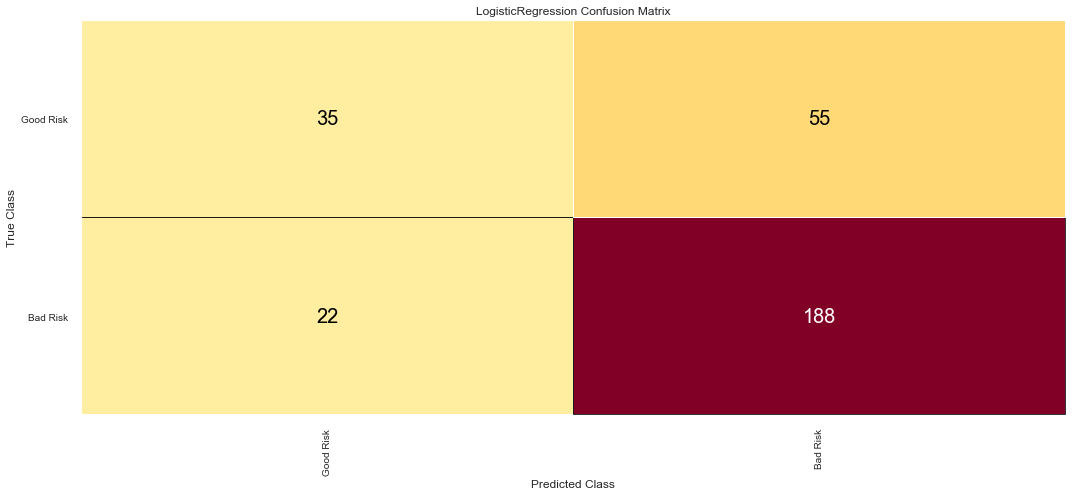

C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


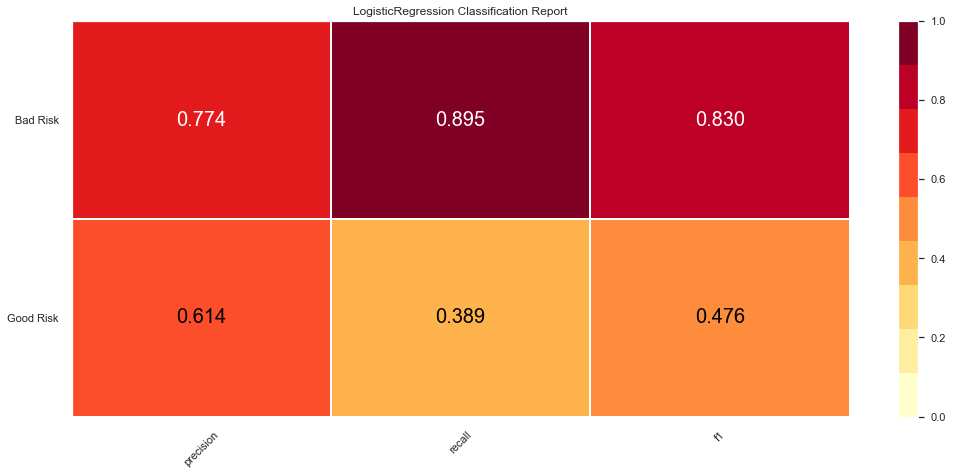

In [54]:
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

# Instantiate the classification model 
model = LogisticRegression()

#The ConfusionMatrix visualizer taxes a model
classes = ['Good Risk','Bad Risk']
cm = ConfusionMatrix(model, classes=classes, percent=False)
#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

#How did we do?
cm.poof()

# Precision, Recall, and F1 Score
# set the size of the figure and the font size 
#%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

C:\Users\hanhk\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


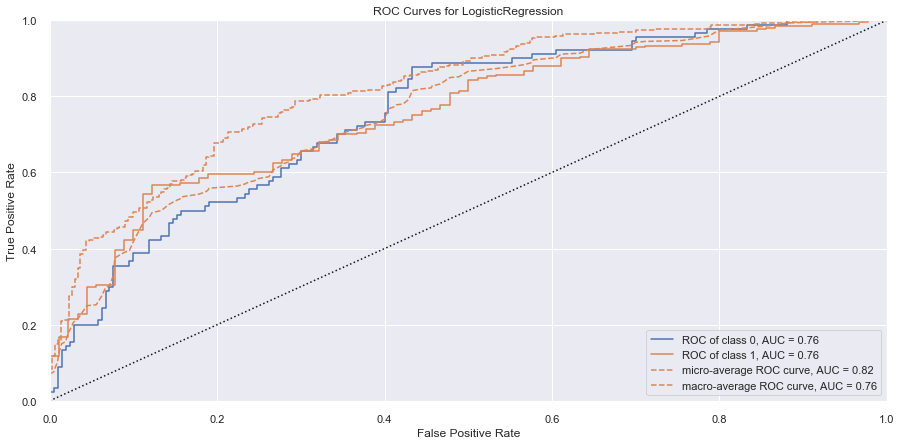

In [55]:
# ROC and AUC
#Instantiate the visualizer
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()


I think it would be interesting to see how the model would react to how the numerical features are treated, leave it as a continuous numerical feature versus when we convert it to categorical dummy

Better at predicting a True Negative, Bad Risk is 0. Avoid a financial loss to the bank